In [245]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pyEX as p
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [246]:
url = 'https://raw.githubusercontent.com/okHotel/ssd_project/master/data_set/daily-min-temperatures.csv'
df = pd.read_csv(url, names=['Date', 'Temp'], skiprows=2556) #carico solo i dati degli ultimi 3 anni
df = df.sort_values(by=['Date']) #ordino i record in base alla data

w = 20
rmean = df.Temp.rolling(window=w, min_periods=1).mean() #calcolo la media mobile
rstd = df.Temp.rolling(window=w, min_periods=1).std() #calcolo la deviazione standard mobile
df['rmean'] = rmean
df['rstd'] = rstd

#df.head()
#fig = px.line(df, x = 'Date', y = 'Temp', title='Mininum temperature trend of Melbourne')
#fig.show()

SVM prevision

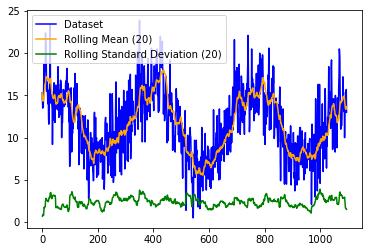

In [247]:
plt.plot(df.Temp, color='blue', label='Dataset')
plt.plot(df.rmean, color='orange', label='Rolling Mean (20)')
plt.plot(df.rstd, color='green', label='Rolling Standard Deviation (20)')
plt.legend(loc='upper left')
plt.show()

Riformatto i Dati in un nuovo DataFrame

In [248]:
df1 = pd.DataFrame()
df1['Date'] = df.Date.copy()
df1['Temp'] = df.Temp.copy()

means = np.concatenate(([0], df.rmean.values.copy())) # creo l'array delle prevsioni con la prima = 0 e scifto tutti gli altri di 1
means = np.resize(means, means.size - 1) # elimino l'ultimo elemento
df1['Prev'] = means # ogni dato è la media mobile calcolata sul dato precedente

stds = np.nan_to_num(np.concatenate(([0], df.rstd.values.copy()))) # creo l'array traslato di 1 delle deviazioni standard
stds = np.resize(stds, stds.size-1) # elimino l'utlimo elemento
df1['Dev Standard'] = stds 

df1['LowerBound'] = df1['Prev'] - df1['Dev Standard'] # lower bound del range entro il quale il dato reale dovrebbe cadere
df1['UpperBound'] = df1['Prev'] + df1['Dev Standard'] # upper bound del range entro il quale il dato reale dovrebbe cadere

pred = (df1['Temp'] >= df1['LowerBound']) & (df1['Temp'] <= df1['UpperBound']) # predicato per verificare se il dato è dentro al range
df1['Class'] = np.where(pred, '1', '0') # predicato soddisfatto mette 1 altrimenti 0
df1.head()

,Date,Temp,Prev,Dev Standard,LowerBound,UpperBound,Class
0,1988-01-01,15.3,0.000000,0.000000,0.000000,0.000000,0
1,1988-01-02,14.3,15.300000,0.000000,15.300000,15.300000,0
2,1988-01-03,13.5,14.800000,0.707107,14.092893,15.507107,0
3,1988-01-04,15.0,14.366667,0.901850,13.464817,15.268517,1
4,1988-01-05,13.6,14.525000,0.801561,13.723439,15.326561,0


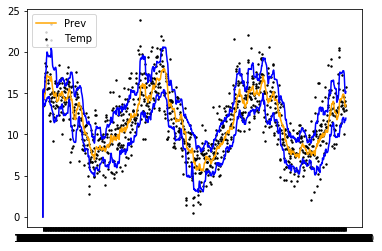

In [249]:
plt.plot(df1.Prev, color='orange', label='Prev')
plt.plot(df1.LowerBound, color='blue')
plt.plot(df1.UpperBound, color='blue')
plt.scatter(df1.Date, df1.Temp, color='black', s=2, label='Temp')
plt.legend(loc='upper left')
plt.show()

In [250]:
# Spilt dataset into train and test
X = df1[['Temp']].values.reshape(-1,1)
Y = df1[['Class']].values.reshape(-1,1).ravel()
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.66, test_size=0.33)

classifier = SVC(kernel='rbf', C=100, gamma=0.2) # classifier definition
classifier.fit(X_train, Y_train) # classifier training
y_pred = classifier.predict(X_test) # classifier prevision

In [251]:
print(confusion_matrix(Y_test,y_pred)) # confusion matrix 
print(classification_report(Y_test,y_pred)) # classification properties
# precision = TP / TP + FP
# recall = TP / TP + FN
# f1 = 2* (Prec * Rec) / (Prec + Rec)

[[ 45  74]
 [ 14 229]]
              precision    recall  f1-score   support

           0       0.76      0.38      0.51       119
           1       0.76      0.94      0.84       243

    accuracy                           0.76       362
   macro avg       0.76      0.66      0.67       362
weighted avg       0.76      0.76      0.73       362

